<a href="https://colab.research.google.com/github/dcolinmorgan/prediction/blob/master/tpu_LTRC_doge_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os,glob,gc
import pandas as pd
import numpy as np
from psutil import *
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import math,keras,time
import tensorflow as tf
# import cupy as cp

timestr = time.strftime("%Y%m%d-%H%M")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',names=['TF','genes'])
##CASE
# np.save('drive/My Drive/LARGE_PANDA/LARGECOPD_time_case',tdata)
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LARGECOPD_time_case.npy'))
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcase.npy'))
# tdata.columns=pd.read_csv('drive/My Drive/LARGE_PANDA/LTRCcase_ages.txt',header=None)[0]
# tdata_ages[0]
# tdata.index=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
# tdata=tdata.T

# #CONTROL
# # np.save('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control',tdata)
# # tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control.npy'))
tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcontrol.npy'))
tdata.columns=pd.read_csv('drive/My Drive/LARGE_PANDA/LTRCcontrol_ages.txt',header=None)[0]
# # tdata_ages[0]
# tdata.index=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
# links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None,names=['TF','gene'])


# t2data=tdata.iloc[:,0:100]
# t2data=tdata[np.abs(np.mean(tdata.iloc[:,10:20],axis=1) - np.mean(tdata.iloc[:,30:40],axis=1))>1.5]

# print(t2data.shape)
# del tdata
# tdata=pd.DataFrame()


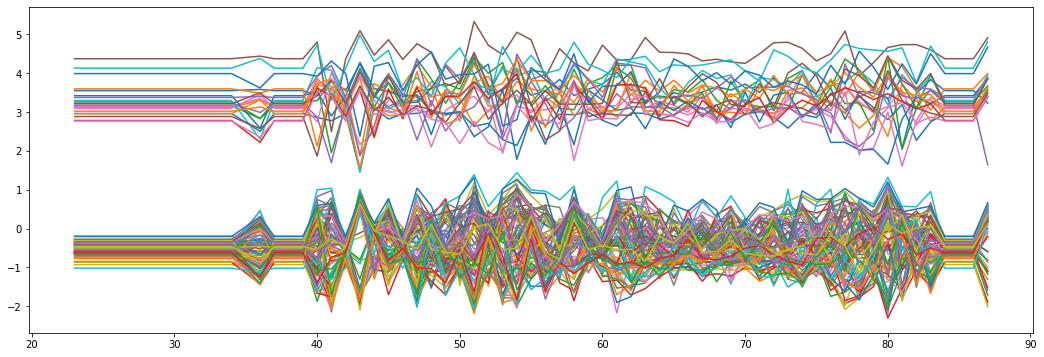

In [4]:
plt.figure(figsize=(18, 6))
w=plt.plot(tdata.T.iloc[:,1:100])

In [5]:
from scipy.stats import zscore
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

from keras.preprocessing import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.models import load_model

from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda,Dropout,Activation,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator

In [6]:
tf.keras.backend.clear_session()
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.46.184.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.46.184.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


##look at data first, normalize

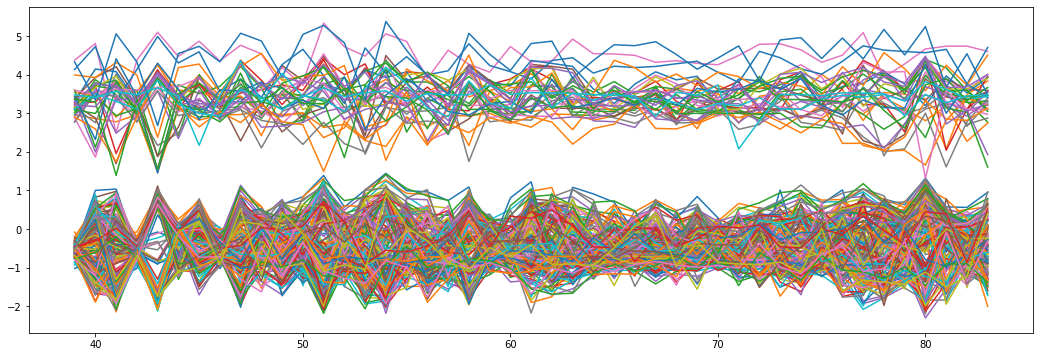

In [9]:
plt.figure(figsize=(18, 6))
w=plt.plot(tdata.T.iloc[8:53,0:200])

In [33]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
t2data = scaler.fit_transform(tdata.T.iloc[8:53,0:20000])#cont_gene_sum.iloc[:,10:50])) #r2data.iloc[:,10:50]))

# X_std = (tdata - tdata.min(axis=0)) / (tdata.max(axis=0) - tdata.min(axis=0))
# X_scaled = X_std * (1 - 0) + 0

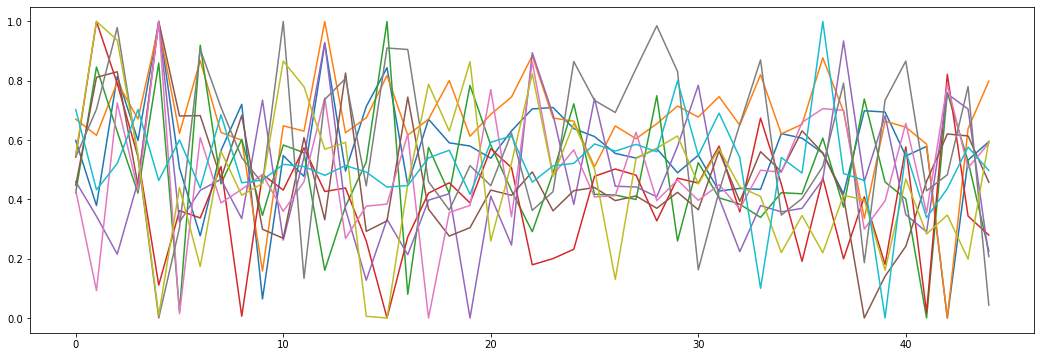

In [34]:
plt.figure(figsize=(18, 6))
w=plt.plot(pd.DataFrame(t2data).iloc[:,0:10])

## initial model (horribly wrong dimensions)

In [10]:
# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# t2data = scaler.fit_transform(np.transpose(tdata.iloc[:,:]))#cont_gene_sum.iloc[:,10:50])) #r2data.iloc[:,10:50]))
# split into train and test sets

# t2data=np.array(tdata.T.iloc[8:53,0:10000])

train_size = int(len(t2data) * 0.68)
test_size = len(t2data) - train_size
train, test = t2data[0:train_size,:], t2data[train_size:(train_size+test_size),:]
print(len(train),len(test))

30 15


In [11]:
look_back=5
training_sequence = TimeseriesGenerator((train), (train), length=look_back,batch_size=look_back)
validation_sequence = TimeseriesGenerator((test), (test),  length=look_back,batch_size=look_back)
print(training_sequence.data.shape,validation_sequence.data.shape)

(30, 20000) (15, 20000)


In [ ]:
model = Sequential()
## graph neural network then (lower D space) to LSTM (neighborhood) NOT conv1d (spatial from images)
initializer=tf.keras.initializers.Orthogonal()
model.add(LSTM(1024, input_shape=(look_back, training_sequence.data.shape[1]),return_sequences=True, kernel_initializer=initializer)) #orthoganal initialization for weight, he  # 5 time steps and 32831 features/genes
# model.add(Activation('relu'))
model.add(Bidirectional(LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add(Bidirectional(LSTM(512,activation='relu',return_sequences=True))),
# model.add(Activation('relu'))
model.add(Bidirectional(LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),

# model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True))),
model.add((LSTM(128,activation='relu',return_sequences=True))),

model.add((LSTM(64,activation='relu'))),
# model.add(Dropout(0.15))
# model.add((LSTM(32,activation='relu'))),
model.add(Dense(training_sequence.data.shape[1]))

model.compile(loss='mse',
              experimental_steps_per_execution = 50,
              optimizer='adam',
              metrics=['mse'])
# print(model.summary())


In [ ]:
callbacks = [
    LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20)),
    EarlyStopping(patience=5, verbose=1),#monitor='loss'),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
tf.config.run_functions_eagerly(False) ## steps per epoch are total time steps / look_back, ie 40 year / 5 lookback

history =model.fit(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)

In [ ]:
model.save('drive/MyDrive/LARGE_PANDA/model_output/Cont_gene_1_'+timestr+'.h')
plot_model(model, to_file='drive/MyDrive/LARGE_PANDA/model_output/Cont_gene_1_'+timestr+'.png', show_shapes=True)
Image(filename='drive/MyDrive/LARGE_PANDA/model_output/Cont_gene_1_'+timestr+'.png')

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_20210414-2043.h')
model.compile(loss='mse',
              experimental_steps_per_execution = 50,
              optimizer='adam',
              metrics=['mse'])

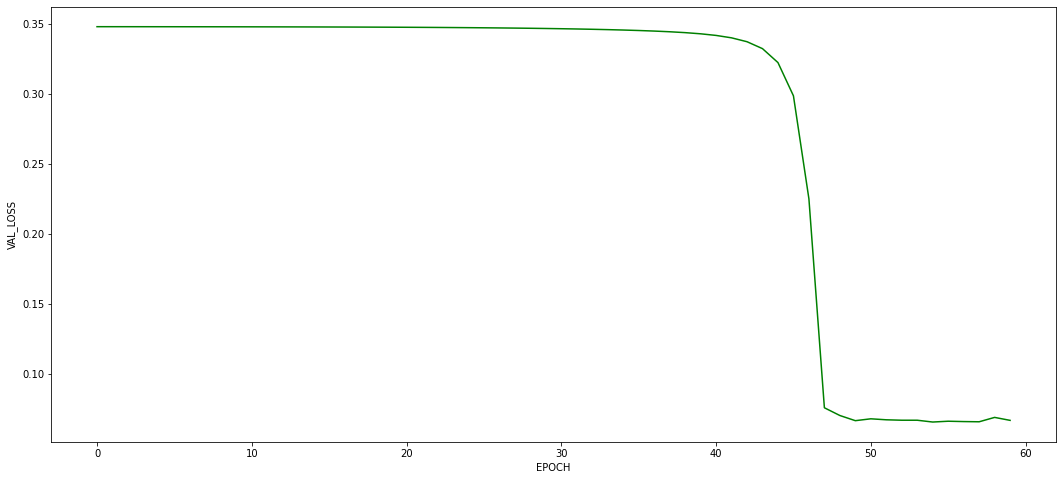

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure(figsize=(18, 8))
plt.plot(hist['epoch'],hist['val_loss'], color= 'green')
# plt.plot(loss, color='red')
# plt.title("Close price of stocks sold")
plt.xlabel("EPOCH")
plt.ylabel("VAL_LOSS")
plt.show()

In [ ]:
# # make predictions
# # trainPredict = model.predict(testX)
# trainPredict = model.predict(t2data[30:].reshape(1,t2data[30:].shape[0],t2data[30:].shape[1]))

# # testPredict = model.predict(testY)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# # trainY = scaler.inverse_transform(trainY)
# # testPredict = scaler.inverse_transform(testPredict)
# # testY = scaler.inverse_transform(testY)
# # calculate root mean squared error
# # trainScore = math.sqrt(mean_squared_error(testX, trainPredict))
# # print('Train Score: %.2f RMSE' % (trainScore))
# # testScore = math.sqrt(mean_squared_error(testY[0], testPredict))
# # print('Test Score: %.2f RMSE' % (testScore))

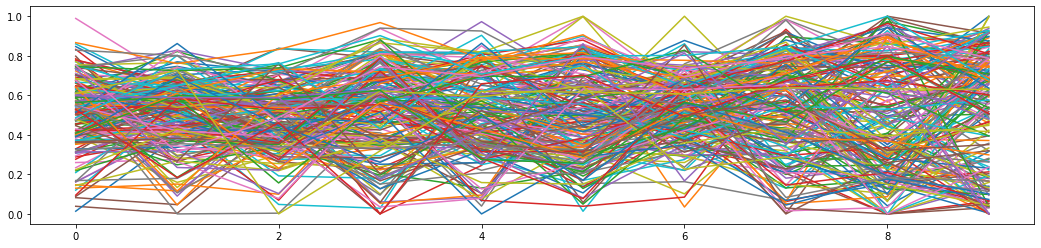

In [ ]:
plt.figure(figsize=(18, 4))
w=plt.plot(t2data[30:40,1:200])#.iloc[0:42,0:9])

In [ ]:
pred_list

In [ ]:
batch =np.expand_dims(t2data[20:30],axis=1)#.reshape(1,t2data[30:40].shape[0],t2data[30:40].shape[1]))
# batch =(t2data[30:40].reshape(1,t2data[30:40].shape[0],t2data[30:40].shape[1]))
cc=batch.shape[1]
pred_list = []
# batch=batch.T
for i in range(cc):
  # print(batch[0,1:,:])
  pred_list.append(model.predict(batch))    #[0])  ## comment T then uncomment
  batch = np.append(batch[0,1:,:],pred_list[i],axis=0)
  # print([batch.shape,pred_list[i].T.shape])
  # batch=batch.T
  # print(pred_list[i])
  # print(pd.DataFrame(batch))
  batch = np.expand_dims(batch, 0)
  # print([i,batch.shape])
# print(pd.DataFrame(np.squeeze(pred_list)))

In [ ]:
    # pred_list=np.expand_dims(pred_list,axis=0)
# pred_list=pd.DataFrame(np.reshape(pred_list,[cc,t2data.shape[1]]))

scaler = MinMaxScaler(feature_range=(0, 1))
pred_list = scaler.fit_transform(pred_list[0])

# scaler = MinMaxScaler()
# scaler.fit(trainA)
# pred_list=scaler.transform((pred_list))
# pred_list = []
# batch = train[-n_input:].reshape((1, n_input, t2data.shape[1]))
# pred_list.append(model.predict(batch.T))
pred_list=(np.squeeze(pred_list))
pred_list=pd.DataFrame(pred_list)
print(pred_list)

# pred=pd.DataFrame(t2data[::-1])[6:]
pred=pd.DataFrame(t2data[:40])
pred=pred.append(pred_list)
pred=pred.reset_index()
del pred['index']

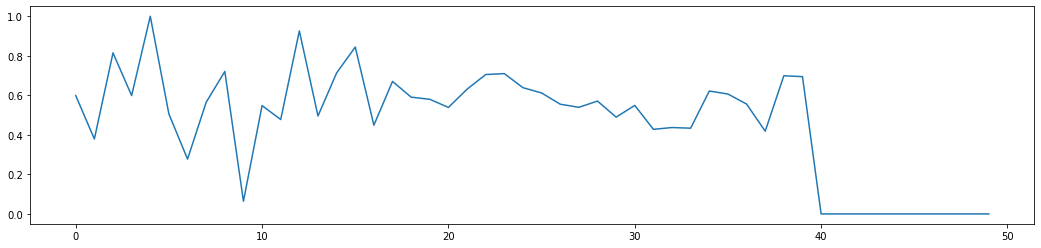

In [ ]:
plt.figure(figsize=(18, 4))
w=plt.plot(pred.iloc[:,0:100])#.iloc[0:42,0:9])
# w=plt.plot(pred_list.iloc[:,1:cc])
# w=plt.plot(t2data[:,10:20])

In [ ]:
trainScore = math.sqrt(mean_squared_error(t2data[30:40], pred_list))
print('Train Score: %.2f RMSE' % (trainScore))


Train Score: 0.55 RMSE


## begin reworked model

[tutorial here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

In [35]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [48]:
dataset=t2data[:,0:200]

In [49]:

# choose a number of time steps
n_steps_in, n_steps_out = 40, 5
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]



In [ ]:
# define model (original)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
  model = Sequential()
  model.add(LSTM(2000, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))
  model.add(LSTM(2000, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(n_features)))
  model.compile(optimizer='adam', loss='mse')
  print(model.summary())

  history = model.fit(X, y, epochs=100)#,verbose=0)

In [25]:
# plot_model(model, show_shapes=True)

In [ ]:
# history = model.fit(X, y, epochs=100)#,verbose=0)

# model.save('drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_'+timestr+'.h')
# plot_model(model, to_file='drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_'+timestr+'.png', show_shapes=True)
# Image(filename='drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_'+timestr+'.png')
# from keras.models import load_model
# # model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_20210414-2043.h')
# model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/420_tutorial_model_'+timestr+'.h')
# model.compile(loss='mse',
#               experimental_steps_per_execution = 50,
#               optimizer='adam',
#               metrics=['mse'])

### expanded model

In [ ]:
## swap in this model
model = Sequential()
## graph neural network then (lower D space) to LSTM (neighborhood) NOT conv1d (spatial from images)
initializer=tf.keras.initializers.Orthogonal()
model.add(LSTM(1024, input_shape=(n_steps_in, n_features), kernel_initializer=initializer)) #orthoganal initialization for weight, he  # 5 time steps and 32831 features/genes
# model.add(Activation('relu'))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
# model.add(RepeatVector(n_steps_out))
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add(Bidirectional(LSTM(512,activation='relu',return_sequences=True))),
# model.add(Activation('relu'))
model.add(Bidirectional(LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),

# model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True))),
model.add((LSTM(128,activation='relu',return_sequences=True))),

model.add(LSTM(64,activation='relu', return_sequences=True))
# model.add(Dropout(0.15))
# model.add((LSTM(32,activation='relu'))),
# model.add(Dense(training_sequence.data.shape[1]))
model.add(TimeDistributed(Dense(n_features)))


model.compile(loss='mse',
              experimental_steps_per_execution = 50,
              optimizer='adam',
              metrics=['mse'])
# print(model.summary())


In [40]:
callbacks = [
    LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20)),
    EarlyStopping(patience=5, verbose=1),#monitor='loss'),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
# tf.config.run_functions_eagerly(False) ## steps per epoch are total time steps / look_back, ie 40 year / 5 lookback
# history = model.fit(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)


# history = model.fit(X, validation_data=y, epochs=300, verbose=0,callbacks=callbacks)



In [ ]:
# model.save('drive/MyDrive/LARGE_PANDA/model_output/420_new_model_'+timestr+'.h')
# plot_model(model, to_file='drive/MyDrive/LARGE_PANDA/model_output/420_new_model_'+timestr+'.png', show_shapes=True)
# Image(filename='drive/MyDrive/LARGE_PANDA/model_output/420_new_model_'+timestr+'.png')
# from keras.models import load_model
# # model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_20210414-2043.h')
# model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/420_new_model_'+timestr+'.h')
# model.compile(loss='mse',
#               experimental_steps_per_execution = 50,
#               optimizer='adam',
#               metrics=['mse'])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure(figsize=(18, 8))
plt.plot(hist['epoch'],hist['val_loss'], color= 'green')
# plt.plot(loss, color='red')
# plt.title("Close price of stocks sold")
plt.xlabel("EPOCH")
plt.ylabel("VAL_LOSS")
plt.show()

### predict

In [ ]:
x_input = np.expand_dims(t2data[0:40,dataset.shape[1]:dataset.shape[1]*2],axis=0)
yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [40]:
[X.shape,y.shape,yhat.shape]

[(1, 40, 200), (1, 5, 200), (1, 5, 200)]

In [42]:
trainScore = math.sqrt(mean_squared_error(yhat[0], y[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.04 RMSE


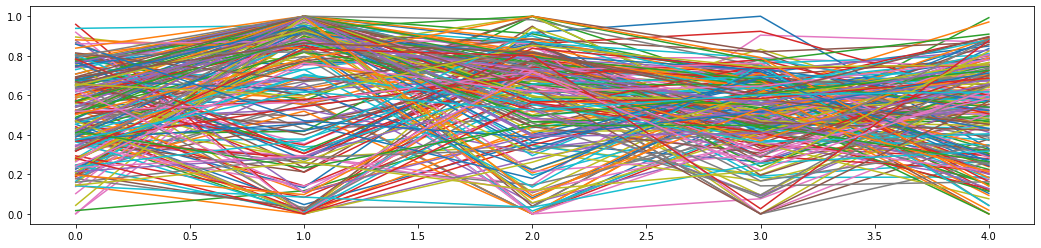

In [43]:
plt.figure(figsize=(18, 4))
c=plt.plot(y[0])

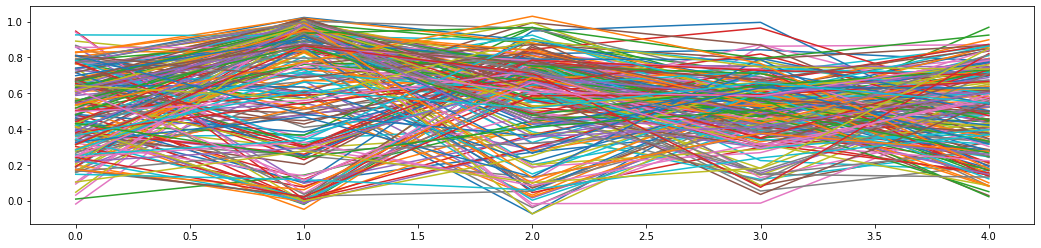

In [44]:
plt.figure(figsize=(18, 4))
c=plt.plot(yhat[0])

In [76]:
t2data[0:40,200:400].shape

(40, 200)